# ML algorithms: Logistic Regression

Source: https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

From the sklearn handbook:

>Logistic regression, despite its name, is a linear model for classification rather than regression. Logistic regression is also known in the literature as logit regression, maximum-entropy classification (MaxEnt) or the log-linear classifier. In this model, the probabilities describing the possible outcomes of a single trial are modeled using a logistic function.

Code: http://marcharper.codes/2016-06-27/Logistic+Regression.html

Slides: https://s3.amazonaws.com/assets.datacamp.com/production/course_15356/slides/chapter4.pdf

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns

In [3]:
distA = stats.norm(30, 5)
distB = stats.norm(15, 4)

data = []
for i in range(100):
    data.append((distA.rvs(), "A"))
    data.append((distB.rvs(), "B"))
    
df = pd.DataFrame(data, columns=["measurement", "class"])
df.head()

,measurement,class
0,31.565639,A
1,17.408465,B
2,30.830071,A
3,17.701917,B
4,24.122060,A


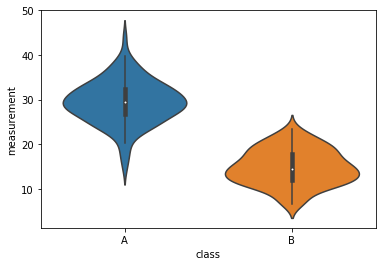

In [4]:
sns.violinplot(x="class", y="measurement", data=df);

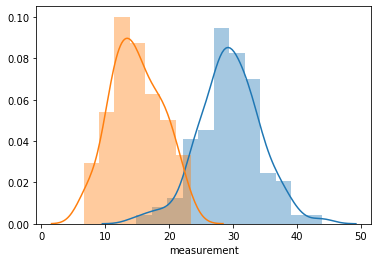

In [5]:
sns.distplot(df[df["class"] == "A"]["measurement"])
sns.distplot(df[df["class"] == "B"]["measurement"]);

In [6]:
# convert categorical values to numbers
df["class_num"] = df['class'].apply(lambda x: 1 if x == 'A' else 0 )
df.head()

,measurement,class,class_num
0,31.565639,A,1
1,17.408465,B,0
2,30.830071,A,1
3,17.701917,B,0
4,24.122060,A,1


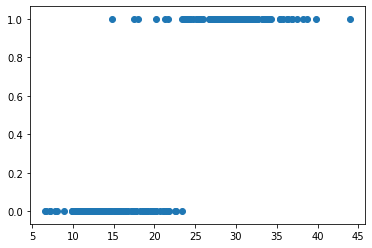

In [7]:
plt.scatter(df["measurement"], df["class_num"])
plt.show()

We could try to use a linear regression to separate the classes. With the best fit line we could label points above and below the line in seperate classes. This works ok (better than no classifier) but has a lot of drawbacks, and logistic regression typically gives a better solution. 

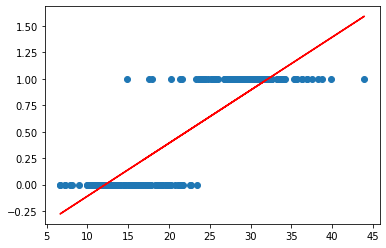

In [8]:
from sklearn import linear_model
X = df[["measurement"]]
y = df["class_num"]
model = linear_model.LinearRegression()
model.fit(X, y)

plt.scatter(df["measurement"], df["class_num"])
plt.plot(df["measurement"], model.predict(X), color="r")
plt.show()

A logistic regression produces a classifier that separates the two classes much more sharply.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


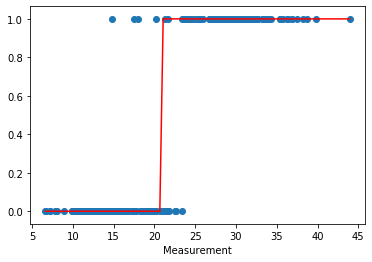

In [9]:
from sklearn import linear_model

df.sort_values(by="measurement", inplace=True)

X = df[["measurement"]]
y = df["class_num"]
model = linear_model.LogisticRegression()
model.fit(X, y)

plt.scatter(df["measurement"], df["class_num"])
plt.plot(df["measurement"], model.predict(X), color="r")
plt.xlabel("Measurement")
plt.show();

We can also plot the predicted probabilities and check the accuracy of the model.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


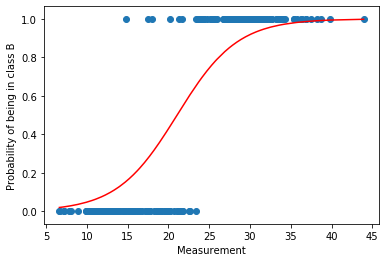

Accuracy 0.94


In [10]:
from sklearn import linear_model

df.sort_values(by="measurement", inplace=True)

X = df[["measurement"]]
y = df["class_num"]
model = linear_model.LogisticRegression()
model.fit(X, y)

plt.scatter(df["measurement"], df["class_num"])
plt.plot(df["measurement"], model.predict_proba(X)[:, 1], color="r")
plt.xlabel("Measurement")
plt.ylabel("Probability of being in class B")
plt.show()

print("Accuracy", model.score(X, y))

Now let's try a set of data that is not so well separated.

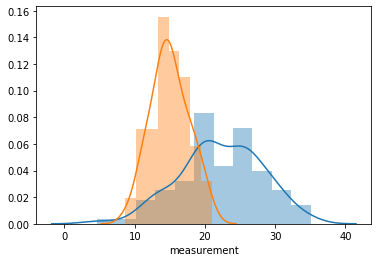

In [11]:
distA = stats.norm(22, 5)
distB = stats.norm(15, 3)

data = []
for i in range(100):
    data.append((distA.rvs(), "A"))
    data.append((distB.rvs(), "B"))
    
df = pd.DataFrame(data, columns=["measurement", "class"])
df["class_num"] = df['class'].apply(lambda x: 1 if x == 'A' else 0 )

sns.distplot(df[df["class"] == "A"]["measurement"])
sns.distplot(df[df["class"] == "B"]["measurement"]);

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


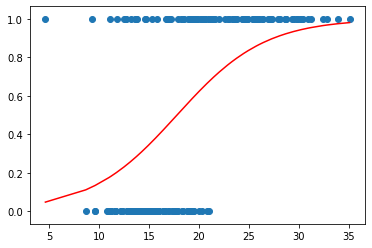

Accuracy 0.825


In [12]:
from sklearn import linear_model

df.sort_values(by="measurement", inplace=True)

X = df[["measurement"]]
y = df["class_num"]
model = linear_model.LogisticRegression()
model.fit(X, y)

plt.scatter(df["measurement"], df["class_num"])
plt.plot(df["measurement"], model.predict_proba(X)[:, 1], color="r")
plt.show()

print("Accuracy", model.score(X, y))

# A more complex real-world example/ analysis

Source: https://github.com/carljv/Will_it_Python/tree/master/ARM/ch5

>Logistic models of well switching in Bangladesh
>Our data are information on about 3,000 respondent households in Bangladesh with wells having an unsafe amount of arsenic. The data record the amount of arsenic in the respondent's well, the distance to the nearest safe well (in meters), whether that respondent "switched" wells by using a neighbor's safe well instead of their own, as well as the respondent's years of education and a dummy variable indicating whether they belong to a community association.

>Our goal is to model well-switching decision. Since it's a binary variable (1 = switch, 0 = no switch), we'll use logistic regression.
>This analysis follows Gelman and Hill Data Analysis Using Regression and Multilevel/Hierarchical Models, chapter 5.4.

In [13]:
import numpy as np
from pandas import *
from statsmodels.formula.api import logit
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrix, dmatrices

In [14]:
df = read_csv('/data/ifu/summerschool/wells.dat', sep = ' ', header = 0, index_col = 0)
df.head()

,switch,arsenic,dist,assoc,educ
1,1,2.36,16.826000,0,0
2,1,0.71,47.321999,0,0
3,0,2.07,20.966999,0,10
4,1,1.15,21.486000,0,12
5,1,1.10,40.874001,1,14


### Model 1: Distance to a safe well
For our first pass, we'll just use the distance to the nearest safe well. Since the distance is recorded in meters, and the effect of one meter is likely to be very small, we can get nicer model coefficients if we scale it. Instead of creating a new scaled variable, we'll just do it in the formula description using the I() function.

In [15]:
model1 = logit('switch ~ I(dist/100.)', data = df).fit()
model1.summary()

Optimization terminated successfully.
         Current function value: 0.674874
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 switch   No. Observations:                 3020
Model:                          Logit   Df Residuals:                     3018
Method:                           MLE   Df Model:                            1
Date:                Fri, 23 Aug 2019   Pseudo R-squ.:                 0.01017
Time:                        14:38:57   Log-Likelihood:                -2038.1
converged:                       True   LL-Null:                       -2059.0
Covariance Type:            nonrobust   LLR p-value:                 9.798e-11
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.6060      0.060     10.047      0.000       0.488       0.724
I(dist / 100.)    -0.6219      0.097     -6.383      0.000      -0.813      -0.431
==================================================================================
"""

In [16]:
def binary_jitter(x, jitter_amount = .05):
    '''
    Add jitter to a 0/1 vector of data for plotting.
    '''
    jitters = np.random.rand(*x.shape) * jitter_amount
    x_jittered = x + np.where(x == 1, -1, 1) * jitters
    return x_jittered

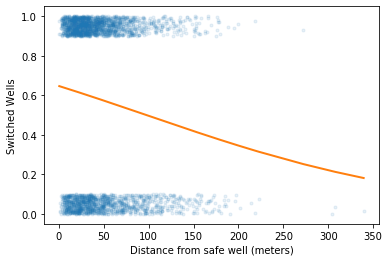

In [17]:
dist_logit_par = model1.params['I(dist / 100.)']
plt.plot(df['dist'], binary_jitter(df['switch'], .1), '.', alpha = .1)
plt.plot(np.sort(df['dist']), model1.predict()[np.argsort(df['dist'])], lw = 2)
plt.ylabel('Switched Wells')
plt.xlabel('Distance from safe well (meters)');

Another way to look at this is to plot the densities of distance for switchers and non-switchers. We expect the distribution of switchers to have more mass over short distances and the distribution of non-switchers to have more mass over long distances.

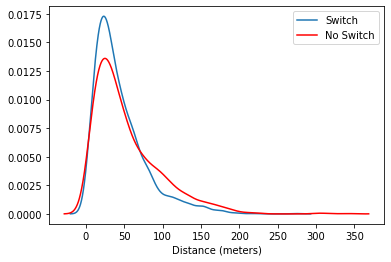

In [74]:
kde_sw = kde = sm.nonparametric.KDEUnivariate(df['dist'][df['switch'] == 1])
kde_nosw = sm.nonparametric.KDEUnivariate(df['dist'][df['switch'] == 0])

kde_sw.fit()
kde_nosw.fit()

plt.plot(kde_sw.support, kde_sw.density, label = 'Switch')
plt.plot(kde_nosw.support, kde_nosw.density, color = 'red', label = 'No Switch')
plt.xlabel('Distance (meters)')
plt.legend(loc = 'best');

#### Model 2: Distance to a safe well and the arsenic level of own well
    
Next, let's add the arsenic level as a regressor. We'd expect respondents with higher arsenic levels to be more motivated to switch.

In [19]:
model2 = logit('switch ~ I(dist / 100.) + arsenic', data = df).fit()
model2.summary()

Optimization terminated successfully.
         Current function value: 0.650773
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 switch   No. Observations:                 3020
Model:                          Logit   Df Residuals:                     3017
Method:                           MLE   Df Model:                            2
Date:                Fri, 23 Aug 2019   Pseudo R-squ.:                 0.04551
Time:                        14:38:58   Log-Likelihood:                -1965.3
converged:                       True   LL-Null:                       -2059.0
Covariance Type:            nonrobust   LLR p-value:                 1.995e-41
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0027      0.079      0.035      0.972      -0.153       0.158
I(dist / 100.)    -0.8966      0.104     -8.593      0.000      -1.101      -0.692
arsenic            0.4608      0.041     11.134      0.000       0.380       0.542
==================================================================================
"""

Which is what we see. The coefficients are what we'd expect: the farther to a safe well, the less likely a respondent is to switch, but the higher the arsenic level in their own well, the more likely.

### Marginal effects
To see the effect of these on the probability of switching, let's calculate the marginal effects at the mean of the data.

In [20]:
argeff = model2.get_margeff(at = 'mean')
print(argeff.summary())

        Logit Marginal Effects       
Dep. Variable:                 switch
Method:                          dydx
At:                              mean
                    dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
I(dist / 100.)    -0.2181      0.025     -8.598      0.000      -0.268      -0.168
arsenic            0.1121      0.010     11.217      0.000       0.092       0.132


So, for the mean respondent, an increase of 100 meters to the nearest safe well is associated with a 22% lower probability of switching. But an increase of 1 in the arsenic level is associated with an 11% higher probability of switching.

#### Class separability
To get a sense of how well this model might classify switchers and non-switchers, we can plot each class of respondent in (distance-arsenic)-space.

We don't see very clean separation, so we'd expect the model to have a fairly high error rate. But we do notice that the short-distance/high-arsenic region of the graph is mostly comprised switchers, and the long-distance/low-arsenic region is mostly comprised of non-switchers.

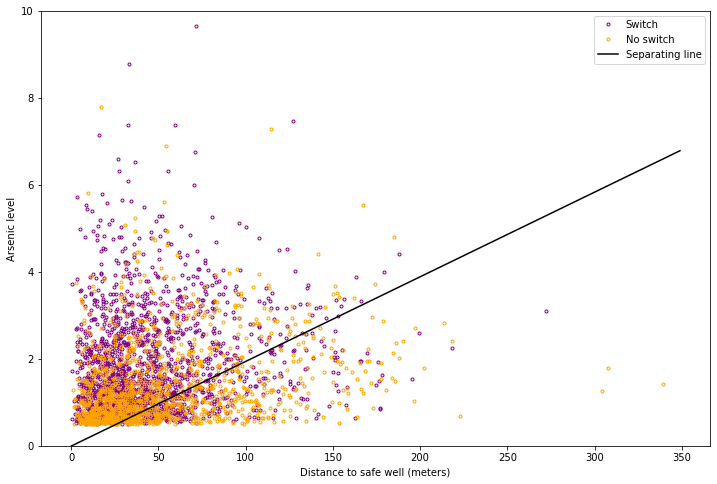

In [21]:
logit_pars = model2.params
intercept = -logit_pars[0] / logit_pars[2]
slope = -logit_pars[1] / logit_pars[2]

dist_sw = df['dist'][df['switch'] == 1]
dist_nosw = df['dist'][df['switch'] == 0]
arsenic_sw = df['arsenic'][df['switch'] == 1]
arsenic_nosw = df['arsenic'][df['switch'] == 0]
plt.figure(figsize = (12, 8))
plt.plot(dist_sw, arsenic_sw, '.', mec = 'purple', mfc = 'None', 
         label = 'Switch')
plt.plot(dist_nosw, arsenic_nosw, '.', mec = 'orange', mfc = 'None', 
         label = 'No switch')
plt.plot(np.arange(0, 350, 1), intercept + slope * np.arange(0, 350, 1) / 100.,
         '-k', label = 'Separating line')
plt.ylim(0, 10)
plt.xlabel('Distance to safe well (meters)')
plt.ylabel('Arsenic level')
plt.legend(loc = 'best');

### Model 3: Adding an interation
It's sensible that distance and arsenic would interact in the model. In other words, the effect of an 100 meters on your decision to switch would be affected by how much arsenic is in your well.

Again, we don't have to pre-compute an explicit interaction variable. We can just specify an interaction in the formula description using the : operator.

In [22]:
model3 = logit('switch ~ I(dist / 100.) + arsenic + I(dist / 100.):arsenic', 
                   data = df).fit()
model3.summary()

Optimization terminated successfully.
         Current function value: 0.650270
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 switch   No. Observations:                 3020
Model:                          Logit   Df Residuals:                     3016
Method:                           MLE   Df Model:                            3
Date:                Fri, 23 Aug 2019   Pseudo R-squ.:                 0.04625
Time:                        14:39:02   Log-Likelihood:                -1963.8
converged:                       True   LL-Null:                       -2059.0
Covariance Type:            nonrobust   LLR p-value:                 4.830e-41
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.1479      0.118     -1.258      0.208      -0.378       0.083
I(dist / 100.)            -0.5772      0.209     -2.759      0.006      -0.987      -0.167
arsenic                    0.5560      0.069      8.021      0.000       0.420       0.692
I(dist / 100.):arsenic    -0.1789      0.102     -1.748      0.080      -0.379       0.022
==========================================================================================
"""

The coefficient on the interaction is negative and significant. While we can't directly intepret its quantitative effect on switching, the qualitative interpretation gels with our intuition. Distance has a negative effect on switching, but this negative effect is reduced when arsenic levels are high. Alternatively, the arsenic level have a positive effect on switching, but this positive effect is reduced as distance to the nearest safe well increases.

### Model 4: Adding educuation, more interactions and centering variables
Respondents with more eduction might have a better understanding of the harmful effects of arsenic and therefore may be more likely to switch. Education is in years, so we'll scale it for more sensible coefficients. We'll also include interactions amongst all the regressors.

We're also going to center the variables, to help with interpretation of the coefficients. Once more, we can just do this in the formula, without pre-computing centered variables.

In [23]:
model_form = ('switch ~ center(I(dist / 100.)) + center(arsenic) + ' +
              'center(I(educ / 4.)) + ' +
              'center(I(dist / 100.)) : center(arsenic) + ' + 
              'center(I(dist / 100.)) : center(I(educ / 4.)) + ' + 
              'center(arsenic) : center(I(educ / 4.))'
             )
model4 = logit(model_form, data = df).fit()
model4.summary()

Optimization terminated successfully.
         Current function value: 0.644328
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 switch   No. Observations:                 3020
Model:                          Logit   Df Residuals:                     3013
Method:                           MLE   Df Model:                            6
Date:                Fri, 23 Aug 2019   Pseudo R-squ.:                 0.05497
Time:                        14:39:04   Log-Likelihood:                -1945.9
converged:                       True   LL-Null:                       -2059.0
Covariance Type:            nonrobust   LLR p-value:                 4.588e-46
===============================================================================================================
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                       0.3563      0.040      8.844      0.000       0.277       0.435
center(I(dist / 100.))                         -0.9029      0.107     -8.414      0.000      -1.113      -0.693
center(arsenic)                                 0.4950      0.043     11.497      0.000       0.411       0.579
center(I(educ / 4.))                            0.1850      0.039      4.720      0.000       0.108       0.262
center(I(dist / 100.)):center(arsenic)         -0.1177      0.104     -1.137      0.256      -0.321       0.085
center(I(dist / 100.)):center(I(educ / 4.))     0.3227      0.107      3.026      0.002       0.114       0.532
center(arsenic):center(I(educ / 4.))            0.0722      0.044      1.647      0.100      -0.014       0.158
===============================================================================================================
"""

#### Model assessment: Binned Residual plots
Plotting residuals to regressors can alert us to issues like nonlinearity or heteroskedasticity. Plotting raw residuals in a binary model isn't usually informative, so we do some smoothing. Here, we'll averaging the residuals within bins of the regressor. (A lowess or moving average might also work.)

In [24]:
model4.resid_response

1       0.298816
2       0.560015
3      -0.728039
4       0.391161
5       0.396564
          ...   
3016   -0.504213
3017   -0.567081
3018   -0.526608
3019   -0.509796
3020    0.480059
Length: 3020, dtype: float64

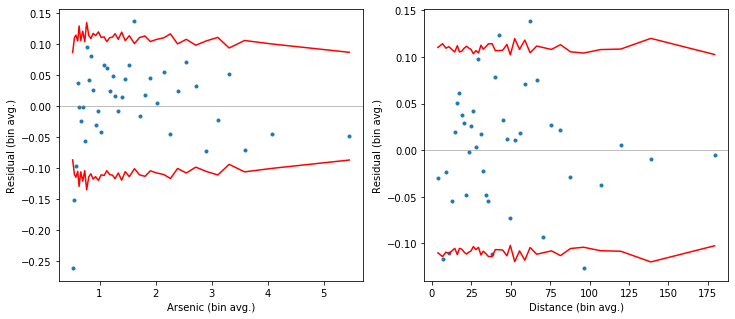

In [25]:
def bin_residuals(resid, var, bins):
    '''
    Compute average residuals within bins of a variable.
    
    Returns a dataframe indexed by the bins, with the bin midpoint,
    the residual average within the bin, and the confidence interval 
    bounds.
    '''
    resid_df = DataFrame({'var': var, 'resid': resid})
    resid_df['bins'] = qcut(var, bins)
    bin_group = resid_df.groupby('bins')
    bin_df = bin_group['var', 'resid'].mean()
    bin_df['count'] = bin_group['resid'].count()
    bin_df['lower_ci'] = -2 * (bin_group['resid'].std() / 
                               np.sqrt(bin_group['resid'].count()))
    bin_df['upper_ci'] =  2 * (bin_group['resid'].std() / 
                               np.sqrt(bin_df['count']))
    bin_df = bin_df.sort_values('var')
    return(bin_df)

def plot_binned_residuals(bin_df):
    '''
    Plotted binned residual averages and confidence intervals.
    '''
    plt.plot(bin_df['var'], bin_df['resid'], '.')
    plt.plot(bin_df['var'], bin_df['lower_ci'], '-r')
    plt.plot(bin_df['var'], bin_df['upper_ci'], '-r')
    plt.axhline(0, color = 'gray', lw = .5)

arsenic_resids = bin_residuals(model4.resid_response, df['arsenic'], 40)
dist_resids = bin_residuals(model4.resid_response, df['dist'], 40)
plt.figure(figsize = (12, 5))
plt.subplot(121)
plt.ylabel('Residual (bin avg.)')
plt.xlabel('Arsenic (bin avg.)')
plot_binned_residuals(arsenic_resids)
plt.subplot(122)
plot_binned_residuals(dist_resids)
plt.ylabel('Residual (bin avg.)')
plt.xlabel('Distance (bin avg.)');

#### Model 5: log-scaling arsenic
The binned residual plot indicates some nonlinearity in the arsenic variable. Note how the model over-estimated for low arsenic and underestimates for high arsenic. This suggests a log transformation or something similar.

We can again do this transformation right in the formula.

In [26]:
model_form = ('switch ~ center(I(dist / 100.)) + center(np.log(arsenic)) + ' +
              'center(I(educ / 4.)) + ' +
              'center(I(dist / 100.)) : center(np.log(arsenic)) + ' + 
              'center(I(dist / 100.)) : center(I(educ / 4.)) + ' + 
              'center(np.log(arsenic)) : center(I(educ / 4.))'
             )

model5 = logit(model_form, data = df).fit()
model5.summary()

Optimization terminated successfully.
         Current function value: 0.639587
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 switch   No. Observations:                 3020
Model:                          Logit   Df Residuals:                     3013
Method:                           MLE   Df Model:                            6
Date:                Fri, 23 Aug 2019   Pseudo R-squ.:                 0.06192
Time:                        14:39:09   Log-Likelihood:                -1931.6
converged:                       True   LL-Null:                       -2059.0
Covariance Type:            nonrobust   LLR p-value:                 3.517e-52
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                          0.3452      0.040      8.528      0.000       0.266       0.425
center(I(dist / 100.))                            -0.9796      0.111     -8.809      0.000      -1.197      -0.762
center(np.log(arsenic))                            0.9036      0.070     12.999      0.000       0.767       1.040
center(I(educ / 4.))                               0.1785      0.039      4.577      0.000       0.102       0.255
center(I(dist / 100.)):center(np.log(arsenic))    -0.1567      0.185     -0.846      0.397      -0.520       0.206
center(I(dist / 100.)):center(I(educ / 4.))        0.3384      0.108      3.141      0.002       0.127       0.550
center(np.log(arsenic)):center(I(educ / 4.))       0.0601      0.070      0.855      0.393      -0.078       0.198
==================================================================================================================
"""

And the binned residual plot for arsenic now looks better.

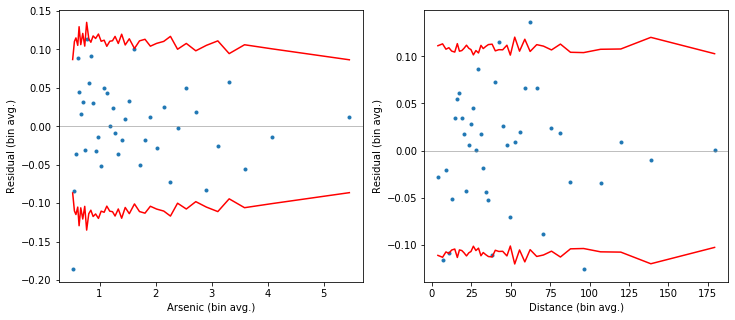

In [27]:
arsenic_resids = bin_residuals(model5.resid_response, df['arsenic'], 40)
dist_resids = bin_residuals(model5.resid_response, df['dist'], 40)
plt.figure(figsize = (12, 5))
plt.subplot(121)
plot_binned_residuals(arsenic_resids)
plt.ylabel('Residual (bin avg.)')
plt.xlabel('Arsenic (bin avg.)')
plt.subplot(122)
plot_binned_residuals(dist_resids)
plt.ylabel('Residual (bin avg.)')
plt.xlabel('Distance (bin avg.)');

#### Model error rates
The pred_table() gives us a confusion matrix for the model. We can use this to compute the error rate of the model.

We should compare this to the null error rates, which comes from a model that just classifies everything as whatever the most prevalent response is. Here 58% of the respondents were switchers, so the null model just classifies everyone as a switcher, and therefore has an error rate of 42%.

In [29]:
print(model5.pred_table())
print(f'Model Error Rate: {1 - np.diag(model5.pred_table()).sum() / model5.pred_table().sum():2.0%}')
print(f' Null Error Rate: {1 - df.switch.mean():2.0%}')

[[ 568.  715.]
 [ 387. 1350.]]
Model Error Rate: 36%
 Null Error Rate: 42%


# Using sklearn

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop('switch', axis=1)
y = df['switch']

In [61]:
# no columns need to be converted to one-hot encoding...

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [69]:
# not needed for logistic regression
# call fit_transform on the training set, but only transform on the test set!
#sc = StandardScaler()
#Xt_train = sc.fit_transform(X_train)
#Xt_test = sc.transform (X_test)

In [70]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [73]:
y_pred = logreg.predict(X_test)
print(f'Accuracy of logistic regression classifier on test set: {logreg.score(X_test, y_test):2.1%}')

Accuracy of logistic regression classifier on test set: 61.9%
